In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d codenamekash/deeplearningchallengeholidays #veri setinin buraya yapıştır



In [ ]:
! unzip /content/deeplearningchallengeholidays.zip

In [3]:
! pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import StratifiedKFold

import albumentations as A
from tqdm import tqdm

In [5]:
IMAGE_SIZE = 64
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 2
image_size = IMAGE_SIZE  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [6]:
num_classes = 6


IMAGE_SHAPE = (IMAGE_SIZE,IMAGE_SIZE,3)
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

train_df = pd.read_csv('/content/dataset/train.csv')
train_df['Kfold']=-1
train_df=train_df.sample(frac=1).reset_index(drop=True)
y=train_df['Class']
kf=StratifiedKFold(n_splits=10)
for fold,(t_,v_) in enumerate(kf.split(X=train_df,y=y)):
    train_df.loc[v_,'Kfold']=fold
train_data_df=train_df[train_df['Kfold']!=4]
valid_data_df=train_df[train_df['Kfold']==4]

In [7]:
train_transforms = A.Compose([
            A.Rotate(limit=40),
            A.Cutout(num_holes=4,max_h_size=8,max_w_size=8),
            A.ShiftScaleRotate(),
            A.RandomRotate90(),
            A.HorizontalFlip(),
            A.VerticalFlip(),
            A.RandomGridShuffle()
        ])

def augumentation_preproc(image):
    data = {"image":image}
    aug_data = train_transforms(**data)
    aug_img = aug_data["image"]
    return aug_img


train_datagen = ImageDataGenerator(rescale=1./255.,  preprocessing_function=augumentation_preproc)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_data_df,
    directory="/content/dataset/train",
    x_col="Image",
    y_col="Class",
    subset="training",
    batch_size=batch_size ,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE),

)

val_datagen = ImageDataGenerator(rescale=1./255.)

valid_generator=val_datagen.flow_from_dataframe(
    dataframe=valid_data_df,
    directory="/content/dataset/train",
    x_col="Image",
    y_col="Class",
    subset="training",
    batch_size=batch_size ,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)

Found 5822 validated image filenames belonging to 6 classes.
Found 647 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [8]:
classes = train_generator.class_indices
classes = dict((v,k) for k,v in classes.items())
# classes = [classes[k] for k in classes]
classes

{0: 'Airplane',
 1: 'Candle',
 2: 'Christmas_Tree',
 3: 'Jacket',
 4: 'Miscellaneous',
 5: 'Snowman'}

In [9]:
def view_images(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset

    fig = plt.figure(figsize=(22, 22))
    for i in range(9):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {classes[np.argmax(label[i])]}")

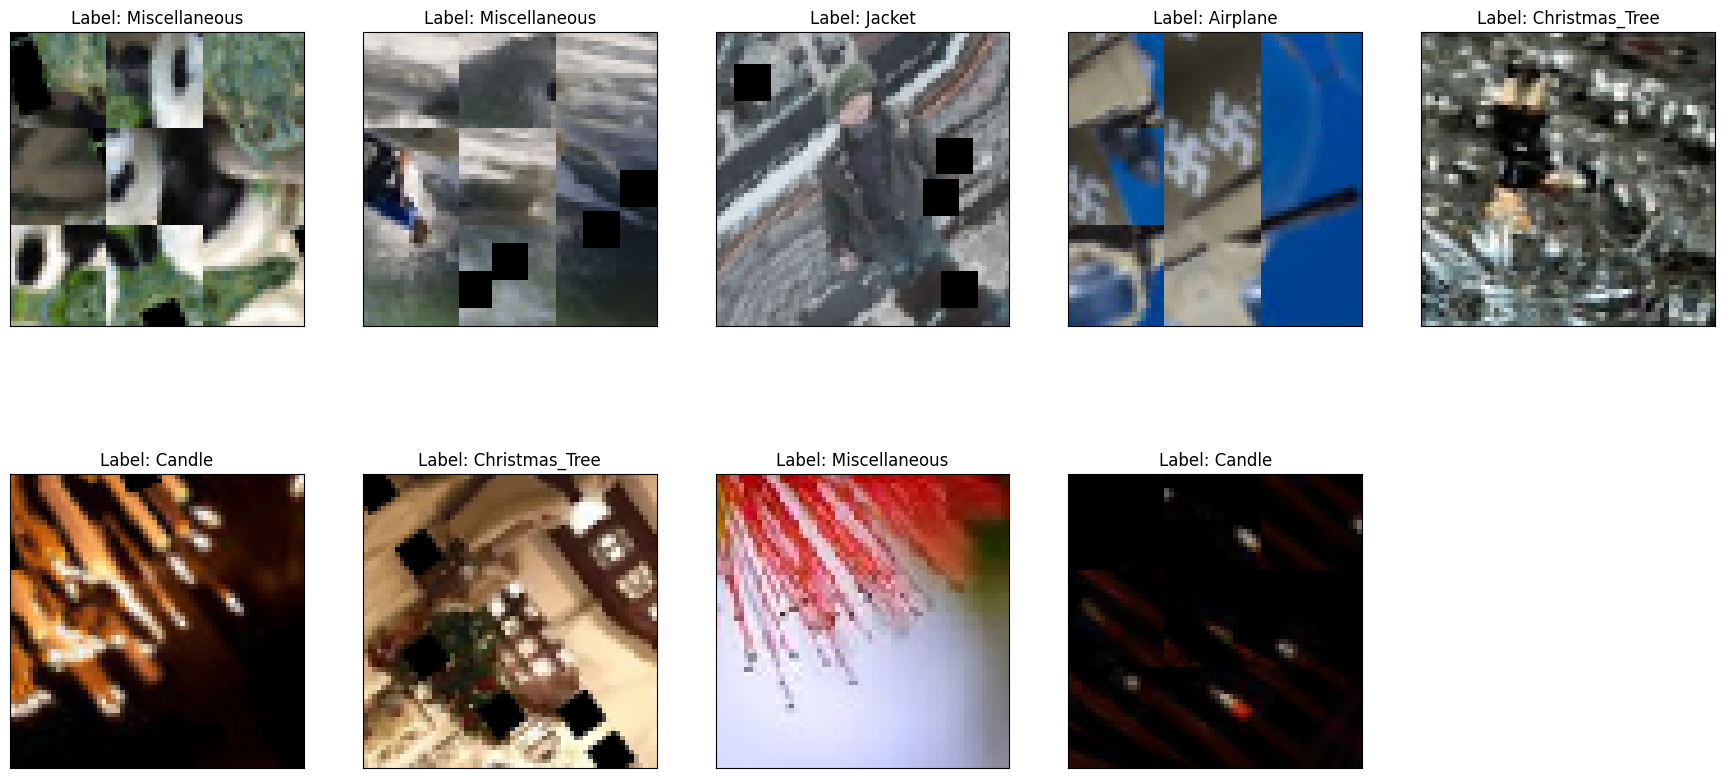

In [10]:
view_images(train_generator)

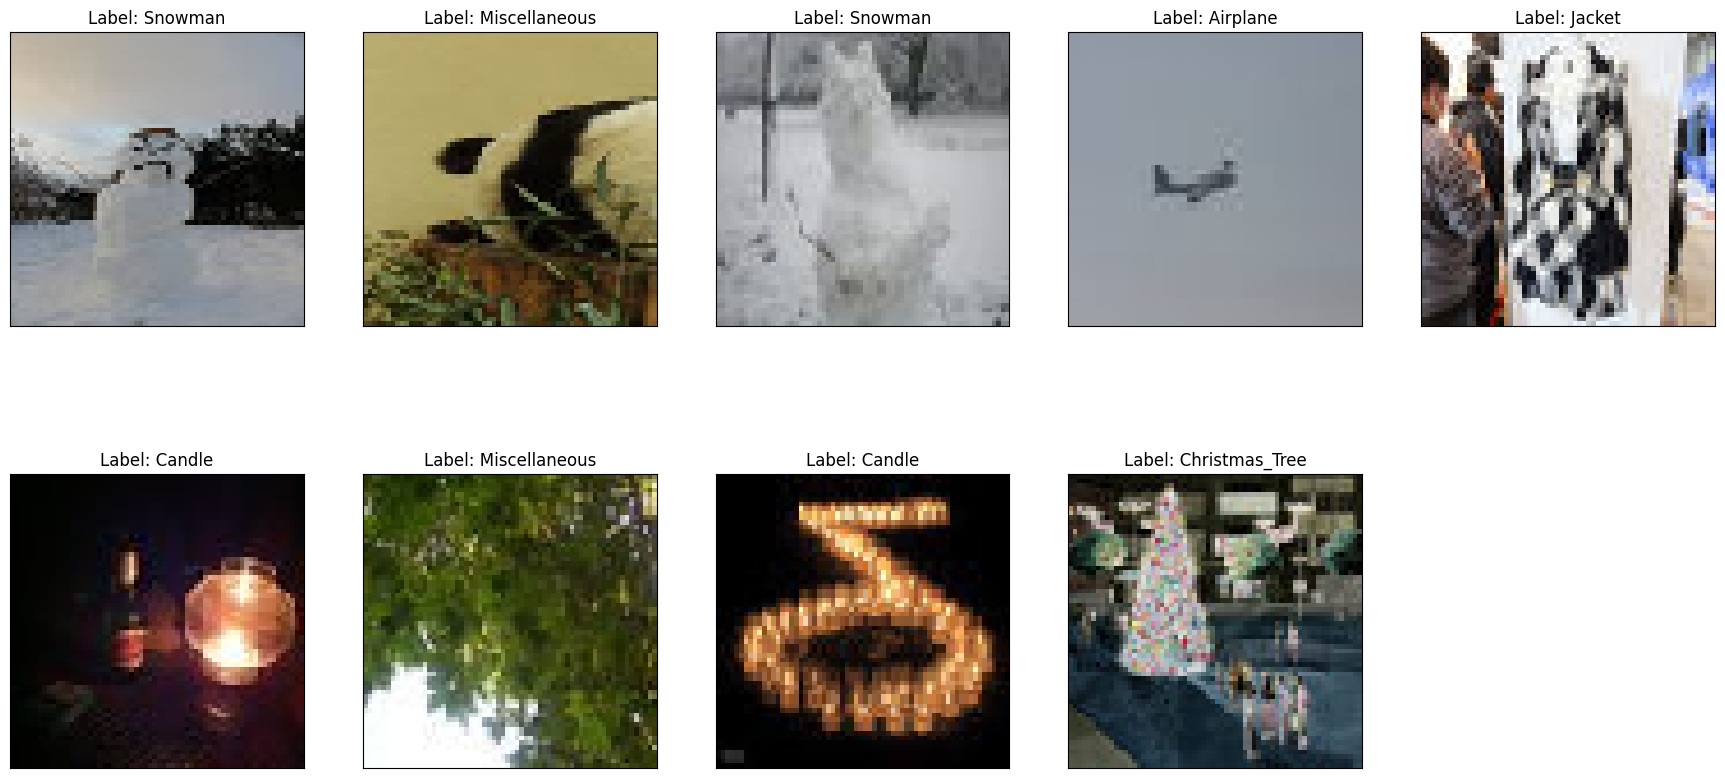

In [11]:
view_images(valid_generator)

In [12]:
counter = Counter(train_generator.classes)
max_val = float(max(counter.values()))
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{5: 7.753846153846154,
 1: 4.719101123595506,
 4: 1.0,
 3: 4.375,
 0: 5.228215767634855,
 2: 1.8194945848375452}

# Use data augmentation

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
#         layers.experimental.preprocessing.RandomFlip("horizontal"),
#         layers.experimental.preprocessing.RandomRotation(factor=0.02),
#         layers.experimental.preprocessing.RandomZoom(
#             height_factor=0.2, width_factor=0.2
#         ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[0].adapt(x_train)

# Implement multilayer perceptron (MLP)

In [14]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Implement patch creation as a layer

In [15]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Implement the patch encoding layer

In [16]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# Build the ViT model

In [17]:
!pip install vit-keras


In [18]:
from vit_keras import vit, utils

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)


    pre_trained_model = vit.vit_l32(
        image_size=IMAGE_SIZE,
        activation='sigmoid',
        pretrained=True,
        include_top=True,
        pretrained_top=True,
        classes=num_classes
    )
    pre_trained_model.trainable = False
    features = pre_trained_model(augmented)
    features = layers.Dense(512, activation=layers.PReLU())(features)
    features = layers.Dropout(0.2)(features)
    features = layers.Dense(256, activation=layers.PReLU())(features)
    features = layers.Dropout(0.2)(features)
    features = layers.Dense(128, activation=layers.PReLU())(features)
    features = layers.Dropout(0.2)(features)

    outputs = layers.Dense(num_classes, activation="softmax")(features)
    model = keras.Model(inputs=inputs,outputs=outputs)
    return model

/usr/local/lib/python3.10/dist-packages/vit_keras/vit.py:139: UserWarning: Can only use pretrained_top with imagenet21k+imagenet2012 if classes = 1000. Setting manually.
  warnings.warn(


1226658854/1226658854 [==============================] - 6s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 2, 2
  warnings.warn(


Epoch 1/2
23/23 [==============================] - 52s 970ms/step - loss: 10.7266 - accuracy: 0.1494 - top-2-accuracy: 0.3172 - val_loss: 1.7188 - val_accuracy: 0.4343 - val_top-2-accuracy: 0.5255
Epoch 2/2
3/3 [==============================] - 1s 239ms/step - loss: 1.7188 - accuracy: 0.4343 - top-2-accuracy: 0.5255
Test accuracy: 43.43%
Test top 2 accuracy: 52.55%


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


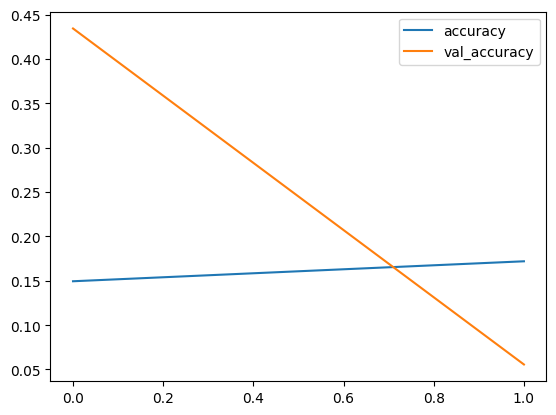

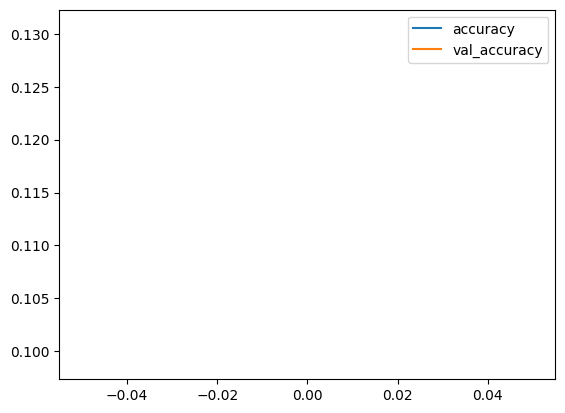

In [19]:
def run_experiment(model):


    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(2, name="top-2-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)
    history = model.fit(
        train_generator,
        batch_size=batch_size,
        epochs=num_epochs,
        class_weight=class_weights,
        validation_data=valid_generator,
        callbacks=[checkpoint_callback,early_stopping],
    )
    pd.DataFrame(history.history)[["accuracy","val_accuracy"]].plot()

    model.trainable = True
    history = model.fit(
        train_generator,
        batch_size=batch_size,
        epochs=num_epochs // 2,
        class_weight=class_weights,
        validation_data=valid_generator,
        callbacks=[checkpoint_callback,early_stopping],
    )

    model.load_weights(checkpoint_filepath)

    _, accuracy, top_2_accuracy = model.evaluate(valid_generator)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 2 accuracy: {round(top_2_accuracy * 100, 2)}%")

    pd.DataFrame(history.history)[["accuracy","val_accuracy"]].plot()
    model.save("./vit_best_model.h5")
    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)